# Calculation of the iso-$T_3^0/T_1^0$ lines on Compressor Map

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
from IPython.display import clear_output

import os

Function for reading `<component>_map/formatted_<values>.txt` files

In [3]:
def read_table(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
    col_vals = df.iloc[0,1:].values
    row_vals = df.iloc[1:,0].values
    central_vals = df.iloc[1:,1:].values
    return col_vals, row_vals, central_vals

Read all the compressor files:

In [36]:
folder = "compressor_map"

# the beta and the speed are sampled at the same points for mass flow, pressure ratios, and iso-efficiencies
beta_comp, speed_comp, mf_vals_comp = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, iso_pr_vals_comp = read_table(f"{folder}/formatted_iso_pressure_ratio.txt")
_, _, iso_eff_vals_comp = read_table(f"{folder}/formatted_iso_efficiency.txt")

surge_df = pd.read_csv(f"{folder}/formatted_surge_line.txt", delim_whitespace=True, header=None)

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\290913450.py:8: FutureWarning: The 'delim_whitespace' keyword i

Post-processing and data interpolation:

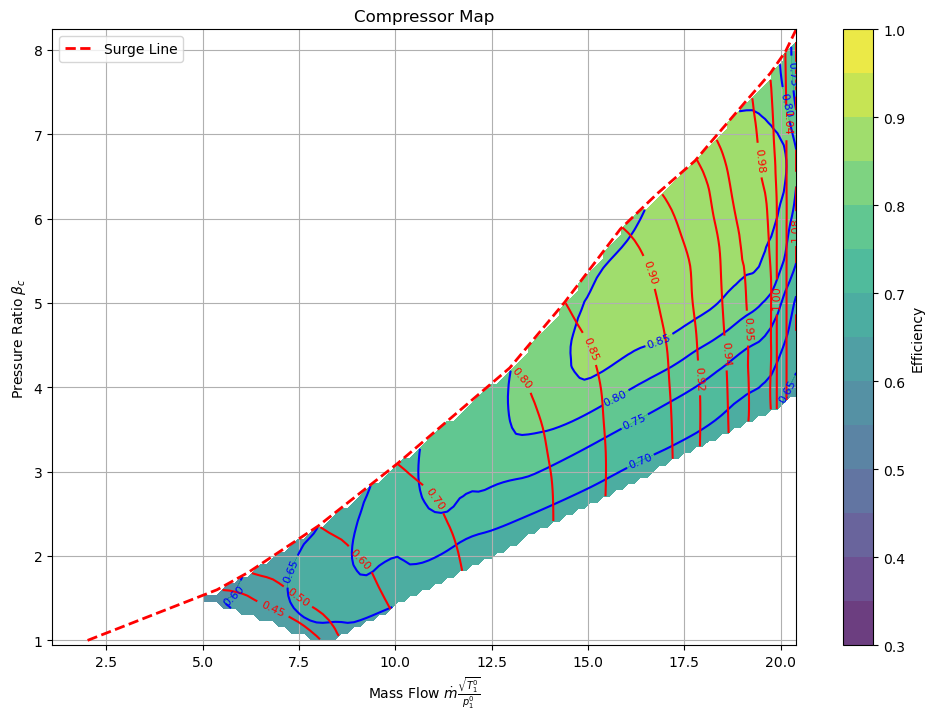

In [196]:
# -----------------------------
# Flatten arrays for interpolation
# -----------------------------
n_rows, n_cols = mf_vals_comp.shape

mf_flat_comp = mf_vals_comp.flatten()
pr_flat_comp = iso_pr_vals_comp.flatten()          # use actual pressure ratio values
eff_flat_comp = iso_eff_vals_comp.flatten()
speed_flat_comp = np.repeat(speed_comp, n_cols)   # repeat speed along columns

# -----------------------------
# Regular grid for plotting
# -----------------------------

num_steps = 100

mf_comp_grid, pr_comp_grid = np.meshgrid(
    np.linspace(mf_flat_comp.min(), mf_flat_comp.max(), num_steps),
    np.linspace(pr_flat_comp.min(), pr_flat_comp.max(), num_steps)
)

# -----------------------------
# Interpolation on grid
# -----------------------------
eff_comp_grid = griddata((mf_flat_comp, pr_flat_comp), eff_flat_comp, (mf_comp_grid, pr_comp_grid), method='cubic')
speed_comp_grid = griddata((mf_flat_comp, pr_flat_comp), speed_flat_comp, (mf_comp_grid, pr_comp_grid), method='cubic')

# -----------------------------
# Surge line mask
# -----------------------------
surge_numbers = surge_df.values.flatten()
n = len(surge_numbers)//2
surge_X, surge_Y = surge_numbers[:n], surge_numbers[n:]
surge_interp = interp1d(surge_X, surge_Y, bounds_error=False, fill_value="extrapolate")
Y_surge_grid = surge_interp(mf_comp_grid[0,:])
Y_mask_grid = pr_comp_grid <= Y_surge_grid[np.newaxis, :]   # broadcast mask

# Apply mask
iso_eff_comp_masked = np.where(Y_mask_grid, eff_comp_grid, np.nan)
speed_comp_grid_masked = np.where(Y_mask_grid, speed_comp_grid, np.nan)

# -----------------------------
# Iso-efficiency contour
# -----------------------------
eff_levels = np.arange(0.3, 1.01, 0.05)
plt.figure(figsize=(12,8))
CF = plt.contourf(mf_comp_grid, pr_comp_grid, iso_eff_comp_masked, levels=eff_levels, cmap="viridis", alpha=0.8)
plt.colorbar(CF, label="Efficiency")
CS_eff = plt.contour(mf_comp_grid, pr_comp_grid, iso_eff_comp_masked, levels=eff_levels, colors='blue', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")

# -----------------------------
# Surge line plot
# -----------------------------
plt.plot(surge_X, surge_Y, 'r--', linewidth=2, label='Surge Line')

# -----------------------------
# Iso-N contour
# -----------------------------
N_levels = np.array([0.45, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.94, 0.955, 0.98, 1.0, 1.04, 1.08])
cs = plt.contour(mf_comp_grid, pr_comp_grid, speed_comp_grid_masked, levels=N_levels, colors='r')
plt.clabel(cs, inline=True, fontsize=8, fmt="%1.2f")

# -----------------------------
# Labels and formatting
# -----------------------------
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_1^0}}{p_1^0}$")
plt.ylabel(r"Pressure Ratio $\beta_c$")
plt.title("Compressor Map")
plt.grid(True)
plt.legend()
plt.show()


Read all the turbine files:

In [197]:
folder = "turbine_map"

# -----------------------------
# Read turbine mass flow
# -----------------------------
beta_turb, speed_turb, mf_vals_turb = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, iso_eff_turb = read_table(f"{folder}/formatted_iso_efficiency.txt")

# Pressure ratio mapping (simple linear scaling, see cell below)
PR_min, PR_max = 0, 3.8
PR_turb = np.linspace(PR_min, PR_max, len(beta_turb))

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style


By looking directly at the turbine map, we see that here the $\beta$ lines are vertical and linearly mapped to the values of the turbine pressure ratio $\beta_t = p_4^0 / p_3^0$
![turbine_map/turbine_map_photo.jpg](turbine_map/turbine_map_photo.jpg)

In [198]:
n_rows, n_cols = mf_vals_turb.shape  # rows = speed, cols = PR

# Crea griglie di PR e N corrispondenti alla matrice originale
PR_grid, N_grid = np.meshgrid(PR_turb, speed_turb)

# Flatten coerente
mf_flat_turb = mf_vals_turb.flatten()
pr_flat_turb = PR_grid.flatten()
speed_flat_turb = N_grid.flatten()
eff_flat_turb = iso_eff_turb.flatten()

mf_turb_grid, pr_turb_grid = np.meshgrid(
    np.linspace(mf_flat_turb.min(), mf_flat_turb.max(), num_steps),
    np.linspace(pr_flat_turb.min(), pr_flat_turb.max(), num_steps)
)

# Now we have two flattened arrays, in mf_values we have all the values of corrected mass flow, 
# in PR_vs_speed_tuples we have, in tuples, the coordinates of each element in mf_values


# Now we want to interpolate
eff_turb_grid = griddata((mf_flat_turb, pr_flat_turb), eff_flat_turb, (mf_turb_grid, pr_turb_grid), method='cubic')
speed_turb_grid = griddata((mf_flat_turb, pr_flat_turb), speed_flat_turb, (mf_turb_grid, pr_turb_grid), method='cubic')

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_17880\625249655.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


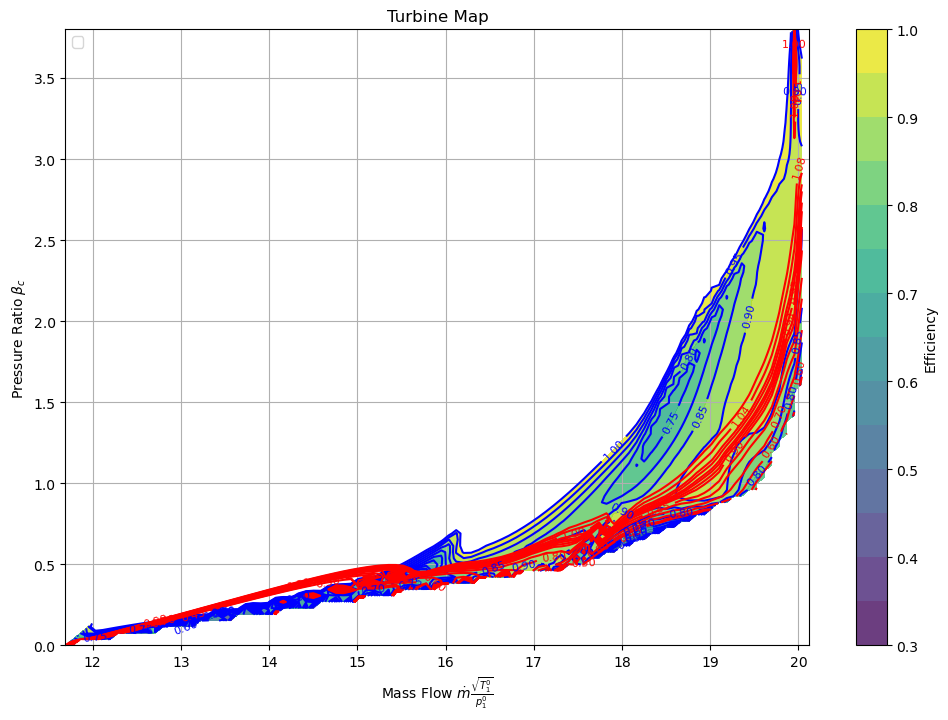

In [199]:

# -----------------------------
# Iso-efficiency contour
# -----------------------------
eff_levels = np.arange(0.3, 1.01, 0.05)
plt.figure(figsize=(12,8))
CF = plt.contourf(mf_turb_grid, pr_turb_grid, eff_turb_grid, levels=eff_levels, cmap="viridis", alpha=0.8)
plt.colorbar(CF, label="Efficiency")
CS_eff = plt.contour(mf_turb_grid, pr_turb_grid, eff_turb_grid, levels=eff_levels, colors='blue', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")


# -----------------------------
# Iso-N contour
# -----------------------------
N_levels = np.array([0.45, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.94, 0.955, 0.98, 1.0, 1.04, 1.08])
cs = plt.contour(mf_turb_grid, pr_turb_grid, speed_turb_grid, levels=N_levels, colors='r')
plt.clabel(cs, inline=True, fontsize=8, fmt="%1.2f")

# -----------------------------
# Labels and formatting
# -----------------------------
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_1^0}}{p_1^0}$")
plt.ylabel(r"Pressure Ratio $\beta_c$")
plt.title("Turbine Map")
plt.grid(True)
plt.legend()
plt.show()


Post-processing and data interpolation:

## Turbine/Compressor Matching

1. Take a point on the compressor map and retrieve the associated values of corrected speed `N_corr` and compressor efficiency `η_c`.  
2. Assume a trial value for the temperature ratio `T3/T1`.  
3. Use this assumed `T3/T1` to retrieve a point on the turbine map, applying the congruence equations (mass and rpm conservations).  
4. Check the pressure congruence between compressor outlet and turbine inlet/outlet.  
5. Iterate adjusting `T3/T1` until pressure congruence is satisfied.


In [200]:
# Constants definition

epsilon_b = 0.99 # [-] Combustor pressure ratio TODO: implement combustor map

epislon_d = 0.99 # [-] Air intake pressure ratio TODO: implement air intake map

beta_n = 2.5 # [-] Nozzle pressure ratio TODO: implement nozzle map

M0 = 0.2 # [-] Assumed aircraft Mach number (actually is an input from the game)

gamma = 1.4 # [-] Air specific heat ratio cp/cv


### Step 1: Take a point on the compressor map

### Step 2: Assume a trail value for `T3/T1`

In [201]:
# Assicurati che siano array numpy float64
iso_eff_comp_masked = np.array(iso_eff_comp_masked, dtype=np.float64)
speed_comp_grid_masked = np.array(speed_comp_grid_masked, dtype=np.float64)

In [202]:

# Maschera dei valori validi
valid_mask = ~np.isnan(iso_eff_comp_masked) & ~np.isnan(speed_comp_grid_masked)
valid_indices = list(zip(*np.where(valid_mask)))

# Prealloca array per salvare
#  il miglior temp_ratio per ogni punto
best_temp_ratios = np.full(iso_eff_comp_masked.shape, np.nan)
best_differences = np.full(iso_eff_comp_masked.shape, np.nan)

# Itera solo sui punti validi
total_points = len(valid_indices)

# Flatten delle griglie
mf_turb_flat = mf_turb_grid.flatten()
pr_turb_flat = pr_turb_grid.flatten()
speed_turb_flat = speed_turb_grid.flatten()
eff_flat = iso_eff_comp_masked.flatten()

for count, (i, j) in enumerate(valid_indices, start=1):
# for count, (i, j) in enumerate(valid_indices[500:600], start=1):
    # Stampa lo stato di avanzamento
    print(f"Processing point {count}/{total_points} -> index (i={i}, j={j})")

    differences = []
    temp_ratios_list = []

    pre_mf_cons_turb =  mf_turb_grid[i, j] / pr_turb_grid[i, j] / epsilon_b
    pre_N_cons_turb = speed_comp_grid_masked[i, j] 

    LHS_pressure_eq = (1 + (gamma - 1) / 2 * M0 ** 2) ** (gamma / (gamma - 1)) * epislon_d * pr_turb_grid[i, j]
    pre_RHS_pressure_eq = beta_n / epsilon_b

    for temp_ratio in np.arange(0.9, 3.9, 0.05):
        
        mf_cons_turb = pre_mf_cons_turb * np.sqrt(temp_ratio) 
        N_cons_turb = pre_N_cons_turb / np.sqrt(temp_ratio)

        distances = np.sqrt((mf_turb_flat - mf_cons_turb)**2 + (speed_turb_flat - N_cons_turb)**2)
        idx_min = np.nanargmin(distances)

        closest_beta = pr_turb_flat[idx_min]

        # Calculate RHS
        RHS_pressure_eq = closest_beta * pre_RHS_pressure_eq
        # and compare it with LHS
        differences.append(abs(LHS_pressure_eq - RHS_pressure_eq))
        temp_ratios_list.append(temp_ratio)

    # Salva il temp_ratio con differenza minima
    min_idx = np.argmin(differences)
    best_temp_ratios[i, j] = temp_ratios_list[min_idx]
    best_differences[i, j] = differences[min_idx]
    clear_output(wait = True)


Processing point 2966/2966 -> index (i=99, j=99)


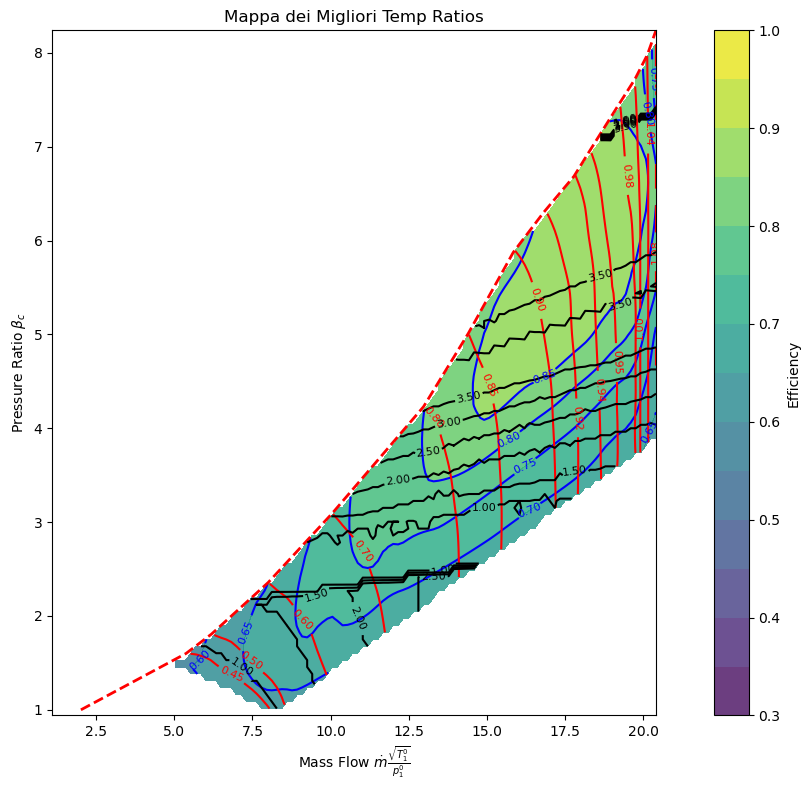

In [203]:
plt.figure(figsize=(12,8))
CF = plt.contourf(mf_comp_grid, pr_comp_grid, iso_eff_comp_masked, levels=eff_levels, cmap="viridis", alpha=0.8)
plt.colorbar(CF, label="Efficiency")
CS_eff = plt.contour(mf_comp_grid, pr_comp_grid, iso_eff_comp_masked, levels=eff_levels, colors='blue', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")

# -----------------------------
# Surge line plot
# -----------------------------
plt.plot(surge_X, surge_Y, 'r--', linewidth=2, label='Surge Line')

# -----------------------------
# Iso-N contour
# -----------------------------
N_levels = np.array([0.45, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.92, 0.94, 0.955, 0.98, 1.0, 1.04, 1.08])
cs = plt.contour(mf_comp_grid, pr_comp_grid, speed_comp_grid_masked, levels=N_levels, colors='r')
plt.clabel(cs, inline=True, fontsize=8, fmt="%1.2f")

# -----------------------------
# iso-Temperature ratio contour
# -----------------------------
temp_ratio_levels = np.arange(0, 4, 0.5)
CS_eff = plt.contour(mf_comp_grid, pr_comp_grid, best_temp_ratios, levels=temp_ratio_levels, colors='black', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")


plt.title('Mappa dei Migliori Temp Ratios')
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_1^0}}{p_1^0}$")
plt.ylabel(r"Pressure Ratio $\beta_c$")

plt.gca().set_aspect(3)
plt.tight_layout()
plt.show()